In [126]:
import pandas as pd
import numpy as np
from scipy import stats, interpolate
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from ipywidgets import interact

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, Product, WhiteKernel, Sum

# get a list of all the colour strings in matplotlib so we can iterate through them
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colour_list = list(colors.keys())
# 9 base colours ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'aliceblue', 'antiquewhite', 'aqua'...

# Behind The Scenes Code

Read in Iteration Data (Training and NNet). Does all of the ugly calculations. Note, when the actions are changed, only self.action_space needs to be changed.

In [127]:
from IterationData import IterationData
# folder = os.path.join('..\Cartpole', 'Data\\')
# iter_data = IterationData(folder, iteration=0)
# iter_data.episode_data['Episode0'].tail()
# iter_data.all_data.tail()

Class To Visualise a Single Iteration. Generally these don't go quite as far as plotting, they create and return an axes object, which can then be plotted, or used in the Visualise class, which compares iterations

In [192]:
# from VisualiseIteration import VisualiseIteration
class VisualiseIteration:
    """
    Uses objects of IterationData, which contians methods to easily access data, summarised below:

    Attributes:
        self.episodes = number of episodes in an iteration
        self.nnet_losses = Dataframe with ['PlayerAction', 'AdversaryAction', 'Value', 'Total'] as the column headders
        self.episode_data = A Dictionary of episodes with keys ['EpisodeN'] where N is an int.
                Each episode's value is a pandas dataframe with columns:

    ['TrueValue', 'PolicyValue', 'MCTSAction', 'PolicyAction', 'MCTSAdv', 'PolicyAdv',  'Observation',      'State2D']
      [ float,      float,         [f, f],        [f, f],      [f, f],     [f, f],  [x, xdot, theta, thetadot], 'arr_n']

        self.all_data = all of the episode data joined in columns as above

    Methods:
        get_state_2d(self, episode, step)
        get_episode_length(self, episode)
        get_max_episode(self)
    """

    def __init__(self, folder_path, iteration):

        self.iter = iteration
        self.action_space = [-1, 1]  # [left, right]
        self.action_names = {0: 'Left', 1: 'Right'}
        self.default_action = 0  # left is default action to show (no need to show left and right)
        self.iter_data = IterationData(folder_path, iteration)

        self.x_threshold = self.iter_data.x_threshold
        self.theta_threshold_radians = self.iter_data.theta_threshold_radians

    def add_axis_valuevsstep(self, episode=None, colour='blue', axes=None):
        # extract data for values and actions
        if episode is None:
            episode = self.iter_data.get_max_episode()
        policy_values = self.iter_data.episode_data['Episode' + str(episode)].PolicyValue
        true_values = self.iter_data.episode_data['Episode' + str(episode)].TrueValue

        # check if subplots already exist
        if axes is None:
            fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(17, 7))

        # Value Subplot
        axes.plot(policy_values, color=colour, linestyle='--',
                  label='Policy Values, Iter:' + str(self.iter) + ' Ep:' + str(episode))
        axes.plot(true_values, color=colour, linestyle='-',
                  label='True Values, Iter:' + str(self.iter) + ' Ep:' + str(episode))
        axes.legend()
        axes.set_ylabel('State Value')

        return axes

    def add_axis_actionvsstep(self, episode=None, colour='blue', axes=None):

        if episode is None:
            episode = self.iter_data.get_max_episode()
        # check if subplots already exist
        if axes is None:
            fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(17, 2 * 7))
        assert isinstance(axes, np.ndarray) and len(axes) == 2, " Not enough Axes"

        # ----- Extract Data -----
        policy_player = self.iter_data.episode_data['Episode' + str(episode)].PolicyAction.values
        mcts_player = self.iter_data.episode_data['Episode' + str(episode)].MCTSAction.values
        policy_adversary = self.iter_data.episode_data['Episode' + str(episode)].PolicyAdv.values
        mcts_adversary = self.iter_data.episode_data['Episode' + str(episode)].MCTSAdv.values

        policy_actions = [list(zip(*policy_player))[self.default_action], list(zip(*policy_adversary))[self.default_action]]
        mcts_actions = [list(zip(*mcts_player))[self.default_action], list(zip(*mcts_adversary))[self.default_action]]
        agent = ['Player', 'Adversary']

        # ----- And Plot on Axes -----
        for axis in range(len(axes)):
            axes[axis].plot(policy_actions[axis], color=colour, linestyle='--',
                       label='{:s}\'s Policy Actions, Iter: {} Ep: {}'.format(agent[axis], self.iter, episode))
            axes[axis].plot(mcts_actions[axis], color=colour, linestyle='-',
                       label='{:s}\'s MCTS Actions, Iter: {} Ep: {}'.format(agent[axis], self.iter, episode))
            axes[axis].legend()
            axes[axis].set_ylabel('Probability of {} Pushing {}'.format(agent[axis], self.action_names[self.default_action]))
            axes[axis].set_xlabel('Steps')

        return axes

    def get_episode_value_stats(self):
        averages = -1 * np.ones((200 + 1,))
        deviations = np.zeros((200 + 1,))
        all_episodes = []
        # print(averages.head())
        for ep in range(self.iter_data.episodes):
            true_values = self.iter_data.episode_data['Episode' + str(ep)].TrueValue.values  # TrueValue or PolicyValue
            all_episodes.append(true_values)
            x = self.iter_data.get_episode_length(ep) + 1
            averages[0:x] += true_values
            averages[x:] += -1
            deviations[0:x] += true_values ** 2
            deviations[x:] += 1

        averages = averages / self.iter_data.episodes
        deviations = np.sqrt(deviations - averages ** 2) / self.iter_data.episodes  # to get the standard deviation
        return averages, deviations, all_episodes

    def plot_observations_histogram(self, normalised=True):

        all_observations = self.iter_data.all_data['Observation'].values

        # normalise all the observations
        if normalised:
            all_normed_observations = []
            for step in all_observations:
                obs = [step[0] / self.x_threshold,
                       step[1] / self.x_threshold,
                       step[2] / self.theta_threshold_radians,
                       step[3] / self.theta_threshold_radians,
                       ]
                all_normed_observations.append(obs)
            all_observations = all_normed_observations
        # flip the dimensions
        all_observations = list(zip(*all_observations))

        # Plot histograms
        fig, axes = plt.subplots(ncols=len(all_observations), nrows=1, figsize=(len(all_observations) * 5, 5))
        obs_label = ['x', '$\dot{x}$', '$\\theta$', '$\dot{\\theta}$']
        axes[0].set_ylabel('Probability of Observation')
        for dim in range(len(all_observations)):
            axes[dim].hist(all_observations[dim], bins=20, density=True, color=colour_list[dim], alpha=0.9)
            if normalised:
                axes[dim].set_xlabel('Normalised ' + obs_label[dim])
            else:
                axes[dim].set_xlabel(obs_label[dim])

    def get_actionvsstate_probs(self, policy, x_dot_fixed=0, theta_dot_fixed=0, bin_proportion=0.15):

        shape = self.iter_data.get_state_2d(episode=0, step=0).shape
        x_dot_bin_size = bin_proportion  # /self.x_threshold # either side of the value
        theta_dot_bin_size = bin_proportion  # /self.theta_threshold_radians # either side of the value

        # only 2 actions currently
        player_probs = np.zeros(shape, dtype=float)
        player_counter = np.zeros(shape, dtype=float)
        adv_probs = np.zeros(shape, dtype=float)
        adv_counter = np.zeros(shape, dtype=float)

        if policy:
            player_act = 'PolicyAction'
            adv_act = 'PolicyAdv'
        else:
            player_act = 'MCTSAction'
            adv_act = 'MCTSAdv'

        player_actions = list(zip(*self.iter_data.all_data[player_act].values))[self.default_action]
        adv_actions = list(zip(*self.iter_data.all_data[adv_act].values))[self.default_action]

        obs = list(zip(*self.iter_data.all_data['Observation'].values))
        state_2ds = self.iter_data.all_data['State2D'].values
        obs0, obs1, obs2, obs3 = np.array(obs[0]), np.array(obs[1]), np.array(obs[2]), np.array(obs[3])

        is_near_x_dot = (obs1 > x_dot_fixed - x_dot_bin_size) & (obs1 < x_dot_fixed + x_dot_bin_size)
        is_near_theta_dot = (obs3 > theta_dot_fixed - theta_dot_bin_size) & (
                    obs3 < theta_dot_fixed + theta_dot_bin_size)
        filtered_player = np.array(player_actions)[is_near_x_dot & is_near_theta_dot]
        filtered_adv = np.array(adv_actions)[is_near_x_dot & is_near_theta_dot]
        filtered_states = np.array(state_2ds)[is_near_x_dot & is_near_theta_dot]

        for idx, arr_num in enumerate(filtered_states):
            state_2d = self.iter_data.state_2ds[arr_num]
            row, column = np.unravel_index(np.argmax(state_2d, axis=None),
                                           shape)  # get the index of the current element

            player_probs[row, column] += filtered_player[idx]
            player_counter[row, column] += 1

            adv_probs[row, column] += filtered_adv[idx]
            adv_counter[row, column] += 1

        player_probs = np.true_divide(player_probs, player_counter)
        adv_probs = np.true_divide(adv_probs, adv_counter)
        return player_probs, adv_probs

    def get_action_correlations(self, plot_scatter=True):
        
        # get data into right format
        player_policy = list(zip(*self.iter_data.all_data['PolicyAction']))[self.default_action]
        adv_policy = list(zip(*self.iter_data.all_data['PolicyAdv']))[self.default_action]
        player_mcts = list(zip(*self.iter_data.all_data['MCTSAction']))[self.default_action]
        adv_mcts = list(zip(*self.iter_data.all_data['MCTSAdv']))[self.default_action]
        player_policy, adv_policy = np.array(player_policy), np.array(adv_policy)
        player_mcts, adv_mcts = np.array(player_mcts), np.array(adv_mcts)
        
        # Instantiate a Gaussian Process model, note DotProduct is just <x, y> == Rotation of linear kernel therefore good for this
        # kernel = Sum(DotProduct(sigma_0=0.1), WhiteKernel(noise_level=0.1)) 
        kernel = Sum(Product(DotProduct(sigma_0=0.1), RBF(0.1, (1e-2, 1e1))), WhiteKernel(noise_level=0.5))
        gp_policy = GaussianProcessRegressor(kernel=kernel, alpha = 0.25**2, n_restarts_optimizer=1)
        gp_mcts = GaussianProcessRegressor(kernel=kernel, alpha = 0.25**2, n_restarts_optimizer=1)

        # Fit to data using Maximum Likelihood Estimation of the parameters
        X_policy, X_mcts = np.atleast_2d(adv_policy).T,  np.atleast_2d(adv_mcts).T
        gp_policy.fit(X_policy, player_policy)
        gp_mcts.fit(X_mcts, player_mcts)
        x = np.atleast_2d(np.linspace(0, 1, 100)).T
        y_policy, s_policy = gp_policy.predict(x, return_std=True)
        y_mcts, s_mcts = gp_mcts.predict(x, return_std=True)
        
        # CALCULATE CORRELATION
        corr_player = np.corrcoef(player_policy, adv_policy)[0][1]  # take a non-diagonal element
        corr_mcts = np.corrcoef(player_mcts, adv_mcts)[0][1]  # take a non-diagonal element
        correlation = [corr_player, corr_mcts]
        
        # SCATTER PLOTS AND FITS
        titles = ['Policy Predictions', 'MCTS Predictions']
        if plot_scatter:
            fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(17, 10))
            player_actions, adv_actions = [player_policy, player_mcts], [adv_policy, adv_mcts]
            y_pred, sigma = [y_policy, y_mcts], [s_policy, s_mcts]
            for axis in range(len(axes)):
                axes[axis].scatter(adv_actions[axis], player_actions[axis], marker = 'x')
                axes[axis].set_title("{}, Correlation Coef: {}".format(titles[axis], correlation[axis]))

                # Plot the function, the prediction and the 95% confidence interval based on the MSE
                axes[axis].plot(x, y_pred[axis], 'b-', label='GP Prediction')
                axes[axis].fill(np.concatenate([x, x[::-1]]),
                         np.concatenate([y_pred[axis] - 1.9600 * sigma[axis],
                                        (y_pred[axis] + 1.9600 * sigma[axis])[::-1]]),
                         alpha=.5, fc='b', ec='None', label='95% confidence interval')
                axes[axis].set_xlabel('p(Adversary Action = Left)')
                axes[axis].set_ylabel('p(Player Action = Left)') 
                axes[axis].set_ylim(0, 1); axes[axis].set_xlim(0, 1)
                axes[axis].legend()
                # plt.show()

    def add_axis_actionprobvsstate(self, prob_array, axes, agent='player', vs=(0.2, 0.8)):

        image = axes.imshow(prob_array, vmin=vs[0], vmax=vs[1],
                            extent=[-self.x_threshold, self.x_threshold, -self.theta_threshold_radians,
                                    self.theta_threshold_radians],
                            cmap='jet', aspect='auto')
        axes.set_xlabel("X-Position")
        axes.set_ylabel("Angular Position")
        axes.set_title('Probability of ' + agent + ' Pushing Left vs Position')

    def plot_state_2d(self, episode, step):
        # Plot MCTS action, action policy and values associated?
        fig = plt.figure()
        axes = fig.add_axes([0, 0, 1, 1])  # add an axis object to the figure
        state_2d = self.iter_data.get_state_2d(episode, step)

        # returns a colourAxisImage, that we need to map the colourbar to the figure
        mapable = axes.imshow(state_2d, extent=[-self.x_threshold, self.x_threshold, -self.theta_threshold_radians,
                                                self.theta_threshold_radians], cmap='jet', aspect='auto')
        axes.set_xlabel("X-Position")
        axes.set_ylabel("Angular Position")
        axes.set_title('The 2D State')

In [193]:
folder = os.path.join('..\Cartpole', 'Data\\')
iter_vis = VisualiseIteration(folder, 2)
# iter_vis.add_axis_valuevsstep(None, colour = 'blue', axes=None)
# iter_vis.add_axis_actionvsstep(None, agent='both', colour = 'blue', axes=None)
# iter_vis.get_episode_value_stats()
# iter_vis.plot_observations_histogram(normalised=True)

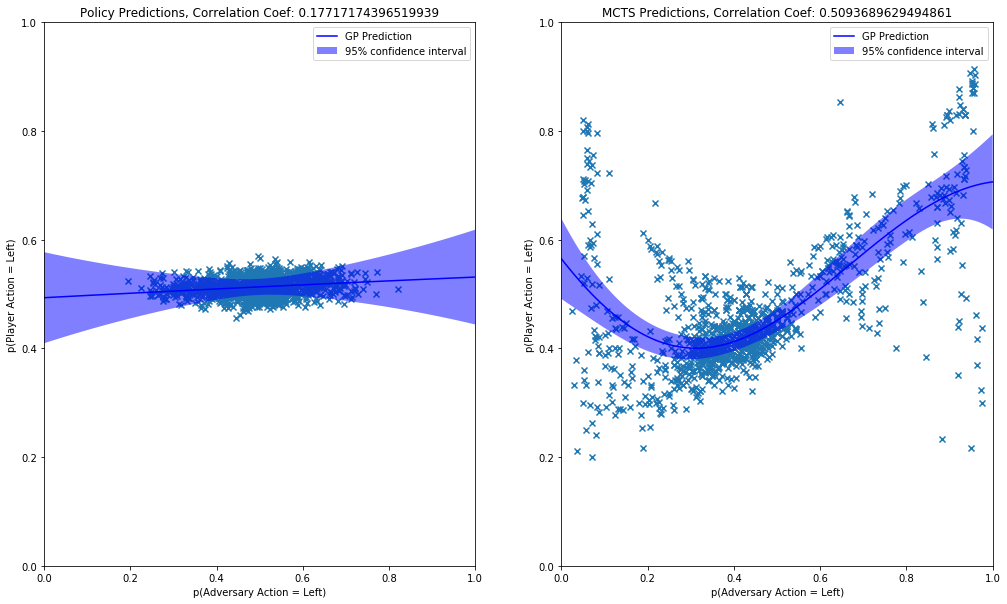

In [194]:
iter_vis.get_action_correlations(plot_scatter=True)

In [155]:
from VisualiseIterations import VisualiseIterations
help(VisualiseIterations)

Help on class VisualiseIterations in module VisualiseIterations:

class VisualiseIterations(builtins.object)
 |  VisualiseIterations principally contains a list of VisualiseIteration objects, which in turn contain Iteration data objects
 |  leading to an objects hirachy of VisualiseIterations <- Iter*VisualiseIteration <- IterationData. The main components of
 |  the two attribute classes are shown below:
 |  
 |  VisualiseIterations:
 |  Attributes:
 |      self.iters_data = [iter_data0, iter_data1, iter_data2, ...]
 |      self.iterations
 |  
 |  VisualiseIteration:
 |  Attributes:
 |      self.iter, self.action_space = [-1, 1], self.action_names ={0: 'Left', 1: 'Right'}
 |      self.default_action = 0  # left is default action to show (no need to show left and right)
 |      iter_data = IterationData(folder_path, iteration)
 |  Methods:
 |      add_axis_valuevsstep(self, episode=None, colour = 'blue', axes=None)
 |      add_axis_actionvsstep(self, episode=None, agent='player', colo

In [6]:
folder = os.path.join('..\Cartpole', 'Data\\')
v = VisualiseIterations(folder, [0, 1, 2])

There are  3  iterations stored in self.iterations


In [7]:
interact(v.vs_state_3d, angle=(0, 180, 5),
         iteration=(0 , v.iterations-1, 1),
         data_set=['PolicyAction', 'MCTSAction', 'PolicyAdv', 'MCTSAdv', 'PolicyValue', 'TrueValue'], 
         omitted_state=['x_dot', 'theta_dot'], 
         omitted_state_value=(-3, 3, 0.1), 
         binsize=(0.05, 2, 0.05))

interactive(children=(IntSlider(value=45, description='angle', max=180, step=5), IntSlider(value=0, descriptio…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

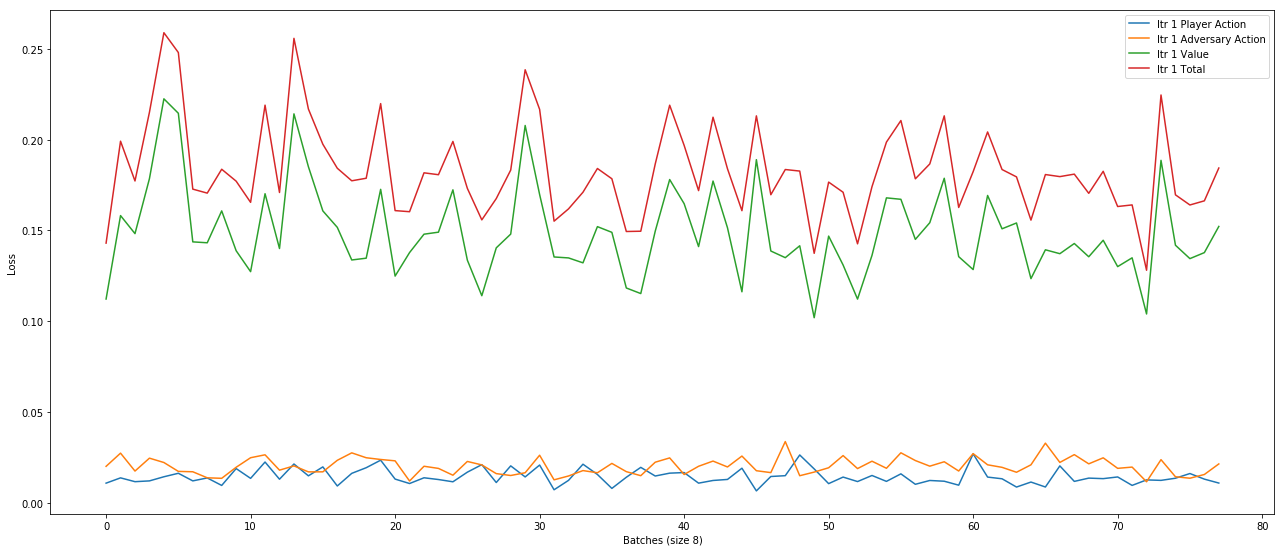

In [10]:
v.plot_nnet_lossesvsbatch(iters=[1])

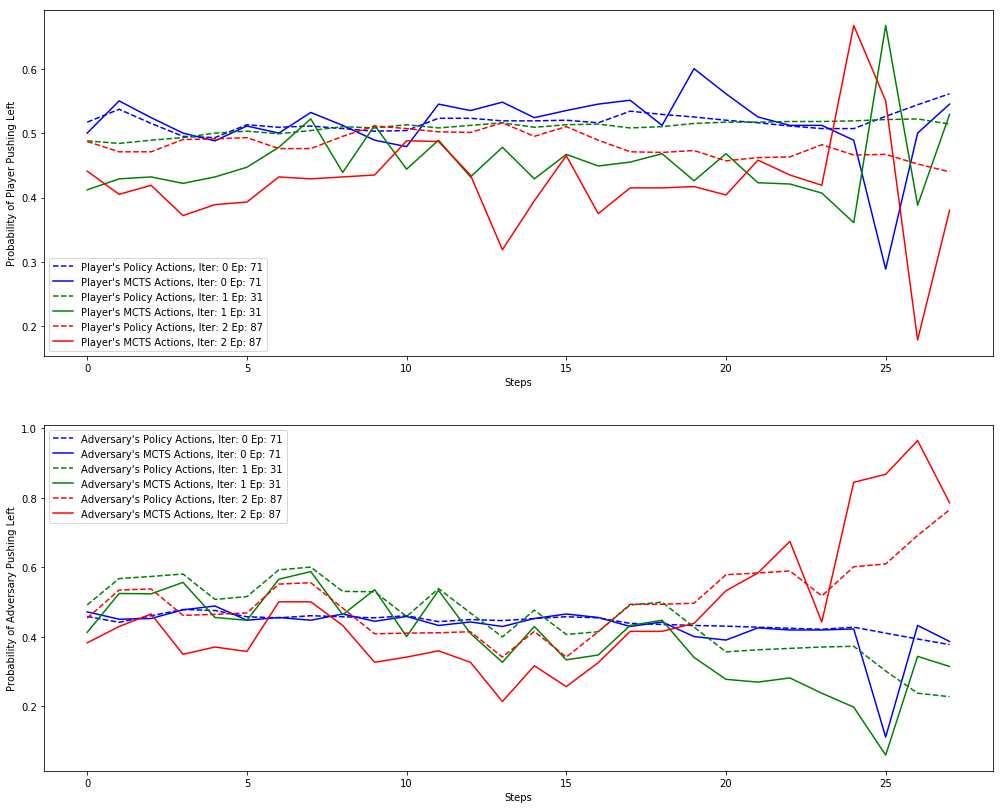

In [12]:
v.plot_actionsvssteps(iters=(0, 1, 2), episodes='longest')

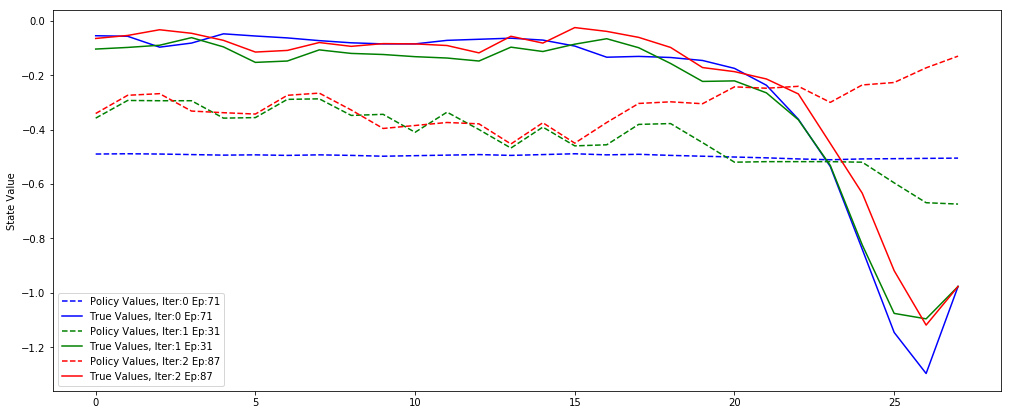

In [13]:
v.plot_valuesvssteps(iters=(0, 1, 2), episodes='longest')

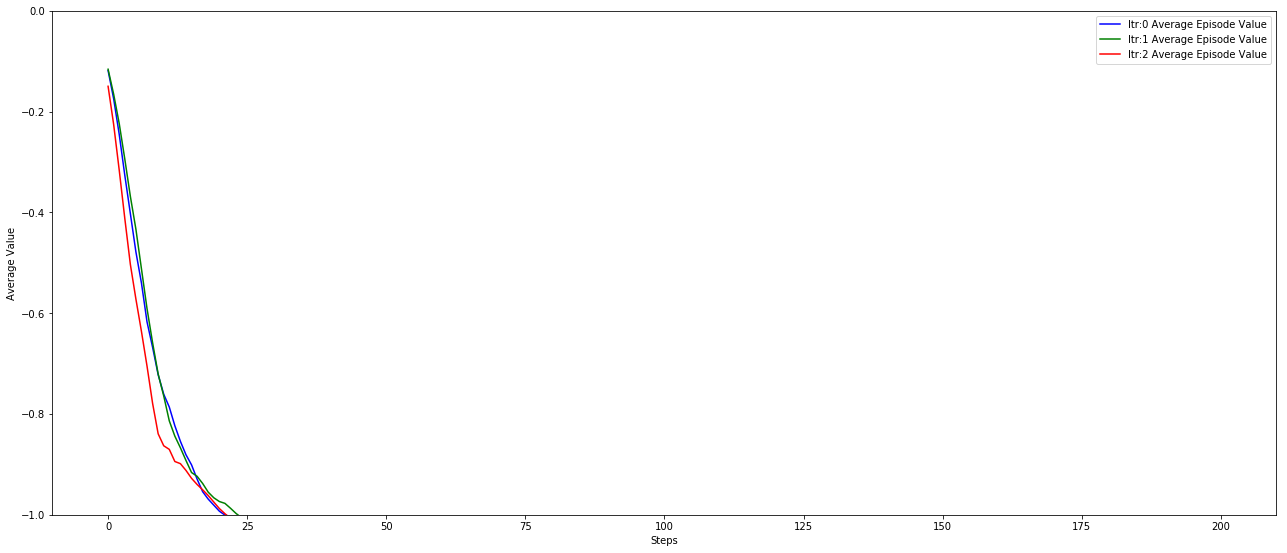

In [14]:
v.plot_episode_statsvsstep()

In [12]:
v.plot_actionprobsvsstates(iters=(0, 1, 2), policy=True, x_dot_fixed=0, theta_dot_fixed=0, bin_prop=0.05, colourbar_lims=(0, 1))

AttributeError: 'VisualiseIteration' object has no attribute 'all_data'

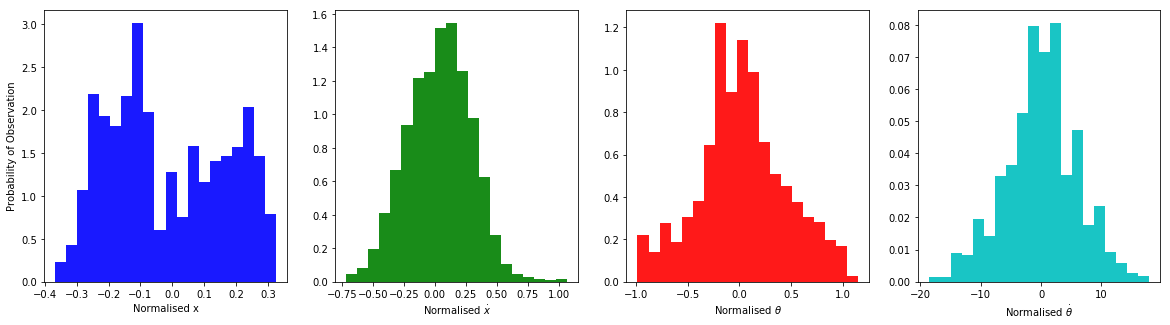

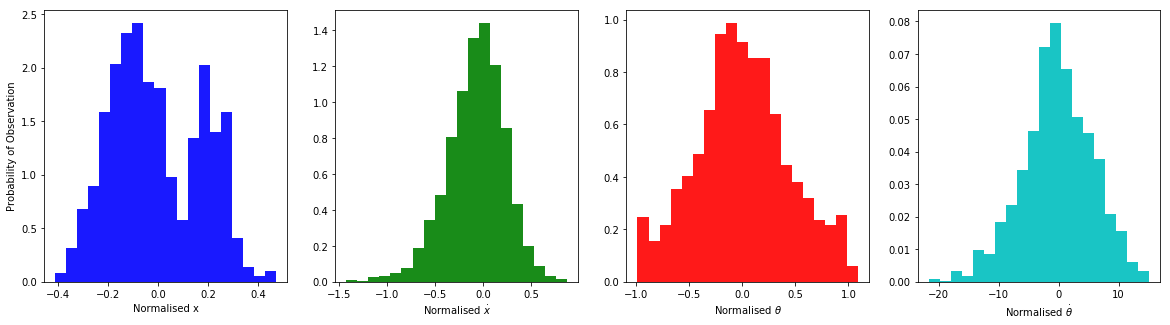

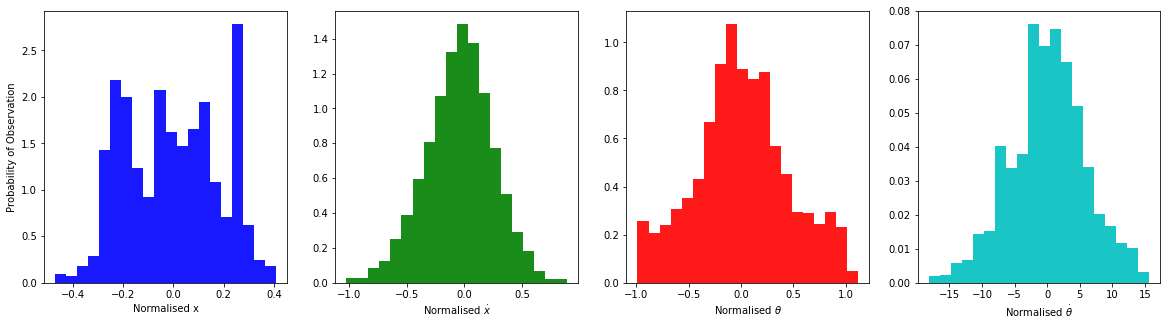

In [13]:
v.plot_observation_histograms(iters=(0, 1, 2), normed=True)